# Case Study - Model Suitability

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

## Aim: Can I use a given model on a given dataset?

We often find ourselves in a situation where we have a pre-trained model for a certain task (e.g. cardiac segmentation) and we have a data set where we want to perform that task. We know the model was not trained on that specific dataset. So we wonder, how will the model perform? Is it usable at all? Do we need to pre-process our data in a certain way to use it?

In this case study we demonstrate how `misas` helps answer these questions with a concrete example:
 - **Model**: [`ukbb_cardiac` network](https://github.com/baiwenjia/ukbb_cardiac) by [Bai et al. 2018 [1]](https://doi.org/10.1186/s12968-018-0471-x), trained on [UK Biobank](https://www.ukbiobank.ac.uk/) cardiac MRI images
 - **Data**: Kaggle [Data Science Bowl Cardiac Challenge Data](https://www.kaggle.com/c/second-annual-data-science-bowl) MRI images

## Prepare Model for `misas`

The used model was trained on UK Biobank cardiac imaging data to segment short-axis images of the heart into left ventricle (LV), right ventricle (RV) and myocardium (MY). For details about the model please read [the paper (Bai et al. 2018)](https://doi.org/10.1186/s12968-018-0471-x) and cite it if you use it. For implementation, training and usage see the [GitHub repository](https://github.com/baiwenjia/ukbb_cardiac). We downloaded the pre-trained model for short-axis images from https://www.doc.ic.ac.uk/~wbai/data/ukbb_cardiac/trained_model/ (local copy in `example/kaggle/FCN_sa`). In order to use it with `misas` we need to wrap it in a class that implements the desired interface (`prepareSize` and `predict` taking `Image` as input, see the main docu for more details).

`ukbb_cardiac` is written in `tensorflow` v1. With `tensorflow` v2 make sure to import the compat module.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.compat.v1 as tf

The model requires images to be a multiple of 16 in each dimension. We pad images accordingly in `prepareSize`. Additionally code in `image_to_input` takes care of the specifics of transforming a three-channel image into a single-item batch of single-channel images. In `predict` the output is converted to `ImageSegment` class.

In [ ]:
class ukbb_model:
    def __init__(self, model_path):
        tf.disable_eager_execution()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(f'{model_path}.meta')
        saver.restore(self.sess, model_path)
        
    def prepareSize(self, image):
        #_, X, Y = image.shape
        X, Y = image.shape
        #print(image.shape)
        image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16))
        #print(image.shape)
        #image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
        return image
    
    def image_to_input(self, image):
        img = image
        img = np.array(img)[:,:,0]
        img = img/255
        img = np.expand_dims(img, 0)
        img = np.expand_dims(img, -1)
        #self.prepareSize(img)
        #print(img.shape)
        ##img_data = np.expand_dims(img, 0)
        #img_data = np.array(img)[0]
        #print(img.shape)
        #img_data = np.expand_dims(img_data, 0)
        #print(img.shape)
        #img_data = np.expand_dims(img_data, -1)
        #print(img.shape)
        return img
    
    def predict(self, image):
        image = self.image_to_input(image)
        preds, classes = self.sess.run(['prob:0', 'pred:0'],
                   feed_dict={'image:0': image, 'training:0': False})
        preds = np.squeeze(preds, 0)
        preds = np.argmax(preds, axis = 2)
        preds = preds.astype(np.uint8)
        preds = Image.fromarray(preds)
        #preds = Image.fromarray(np.array(preds))
        #classes = ImageSegment(ByteTensor(classes))
        
        return preds #classes,
        

In [ ]:
model = ukbb_model('example/kaggle/FCN_sa')

INFO:tensorflow:Restoring parameters from example/kaggle/FCN_sa


## Prepare Dataset for `misas`

The [Data Science Bowl Cardiac Challenge Data](https://www.kaggle.com/c/second-annual-data-science-bowl) consists of MRI cine images from 1140 patients in dicom format. Multiple slices in short axis are available for each patient. Additionally, end-systolic and end-diastolic volumes are given (the original Kaggle challenge asked participants to predict these from the images).

You can download and unpack the dataset from the above website. Some example images are included in the `example/kaggle/dicom` folder.

We use `fastai2.medical.imaging` to read the images and convert them to fastai v1 `Image` objects.

In [ ]:
from fastai.vision.all import *
#from fastai.medical.imaging import *
from pydicom import dcmread
import torch
import torchvision
import torchvision.transforms as t
#from fastai2.medical.imaging import dcmread
from misas.core import default_cmap, default_cmap_true_mask
import warnings
from matplotlib.pyplot import imshow

warnings.filterwarnings('ignore')

In [ ]:
def prepareImage(fname):
    ds = dcmread(fname)
    img = (ds.pixel_array.astype(np.int16))
    img = (img/img.max()*255).astype(np.uint8)
    img = Image.fromarray(np.array(img))
    return img.convert("RGB")
    

In [ ]:
#img = prepareImage("example/kaggle/117_sax_76_IM-11654-0005.dcm")
#np.array(img)[:,:,0]

#img = (ds.pixel_array.astype(np.int16))
#img = (img/img.max()*255).astype(np.uint8)
#img = Image.fromarray(np.array(img))
#return img.convert("RGB")

In [ ]:

#np.array(img.convert("RGB")).shape

AxesImage(54,36;334.8x217.44)
(256, 192)


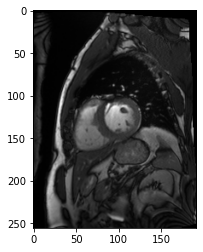

In [ ]:
img = prepareImage("example/kaggle/117_sax_76_IM-11654-0005.dcm")
print(imshow(img))
print(img.shape)

#print(img)
#img2=np.squeeze(img, axis=0)
#print(img2.shape)
#pred=model.predict(img)
#imshow(pred)


In [ ]:
#np.array(img).shape
#img.shape

In [ ]:
#pred2 = pred.astype(np.uint8)
#pred2 = Image.fromarray(pred2)
#imshow(pred2)


In [ ]:
#img = prepareImage("example/kaggle/117_sax_76_IM-11654-0005.dcm")
#pred=model.predict(img)
#imshow(pred)
#print(img)
#print((img.shape))
#print(np.array(img))

In [ ]:
#pred.shape
#pred2 = np.argmax(pred, axis = 2)
#pred2.shape
#imshow(pred2)

We use the window information within the dicom file to scale pixel intensities accordingly.

In [ ]:
#def read_dcm(fname):
#   #dcm = Path(fname).dcmread()
#    dcm = dcmread (Path(fname))
#    pixels = (dcm.pixels.windowed(dcm.WindowWidth, dcm.WindowCenter)).unsqueeze(0)
#    #dcm1 = torch.tensor([dcm.WindowWidth, dcm.WindowCenter])
#    #pixels = dcm1.unsqueeze(0)
#    pixels = torch.cat((pixels,pixels,pixels), dim=0)
#    return Image(pixels)
#    #return Image.fromarray(np.array(pixels))

Okay, let's look at an example:

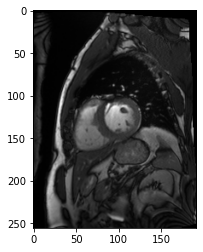

In [ ]:
img = prepareImage("example/kaggle/117_sax_76_IM-11654-0005.dcm")
#img.show(figsize=(8,8))
imshow(img)

#print(img.shape)
#print(img.shape [0][2])
#print(img.shape [1][2])
#imshow(img)

In [ ]:
#dcm = dcmread(Path("example/kaggle/117_sax_76_IM-11654-0005.dcm"))
#print(dcm)
#img = model.prepareSize(img)
#print(type(img))
#imshow (img)
#img.shape
#shape [0][2]
#shape [1][2]
#prepareImage ("example/kaggle/117_sax_76_IM-11654-0005.dcm")


## How does the model perform out of the box?

Time to apply the model to the example image and see how it works (we need to call `prepareSize` manually here):

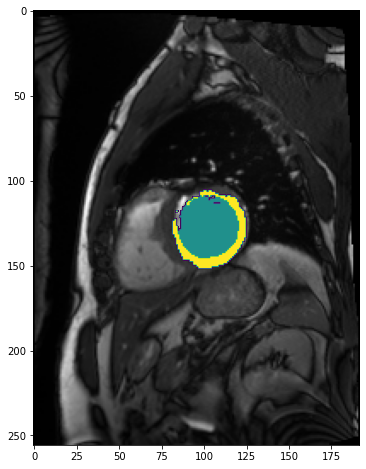

In [ ]:
#img = model.prepareSize(img)
fig,ax = plt.subplots(figsize=(8,8))
imshow(img)
#model.predict(img)[0].show(ax=ax, cmap=default_cmap)
pred=model.predict(img)
imshow(pred, cmap=default_cmap)

The model identified the left ventricle and myocardium partially. It failed to identify the right ventricle. So this result is promising in that it shows some kind of success but it is not usable as it is.

> Note: This is neither surprising nor a critique on the `ukbb_cardiac` network. That network was trained specifically for UK Biobank images and not to be applied generally.

Still, we might be able to use it on the kaggle dataset if we understand why it fails and properly pre-process the data. This is where `misas` comes in. But first look at some more examples to see if we selected a bad example by chance.

In [ ]:
from glob import glob

NameError: name 'read_dcm' is not defined

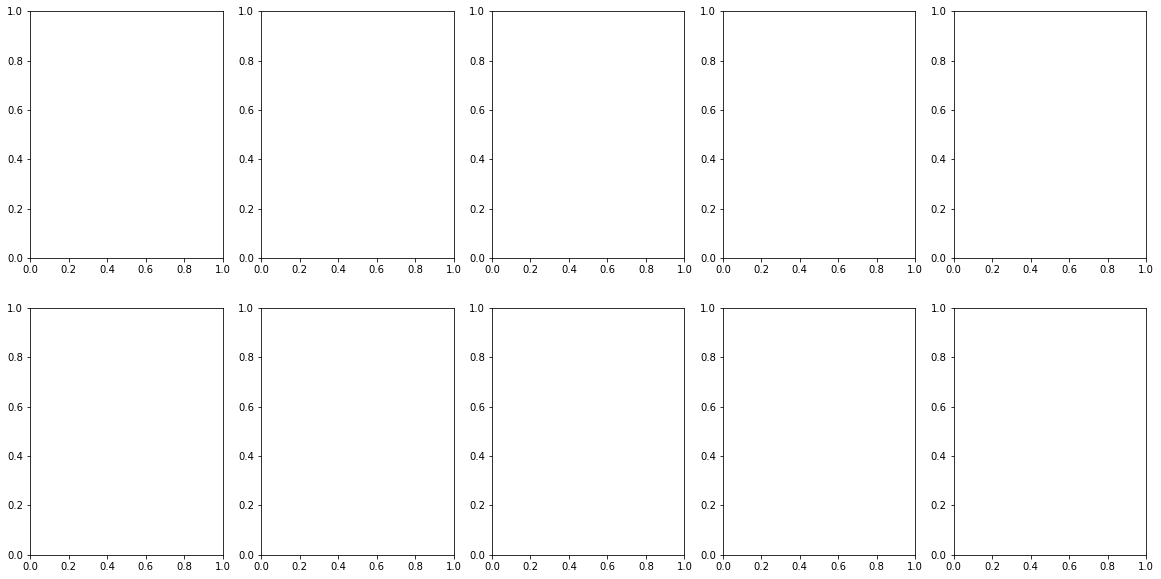

In [ ]:
dcm_files = glob("example/kaggle/sample_images/*.dcm")
fig, axs = plt.subplots(2,5, figsize=(20,10))
for i, ax in enumerate(axs.flatten()):
    tmp = model.prepareSize(read_dcm(dcm_files[i]))
    tmp.show(ax=ax)
    #model.predict(tmp)[0].show(ax=ax, cmap=default_cmap)
    model.predict(img).imshow(cmap=default_cmap)

Apparently our first impression that it does not work out of the box applies to most images. This also shows a bit of the variety of images and quality and also some inconsistencies in orientation.

> Warning: Class colors might not be consistent if some class is completely missing from the prediction

## Analysis of one image

In order to get more detailed insights into what's happening we select a specific example and define two helper functions that will open the image and true mask for that example. We use functions to get the image from file again instead of loading the image once and passing it around to avoid working with an accidentally modified version of the image.

In this case we have the true mask from a previous experiment but it would be possible to create that mask manually as well, it just needs to be saved as png with pixel values `0` for background and `1` to `n` for the `n` classes. As there are only three clases in this case looking at the png image in a standard image viewer will look like a purely black image.

In [ ]:
from misas.core import *

In [ ]:
img = lambda: Image.open("example/kaggle/images/1-frame014-slice006.png").convert("RGB")
trueMask = lambda: Image.open("example/kaggle/masks_full/1-frame014-slice006.png").convert("I")

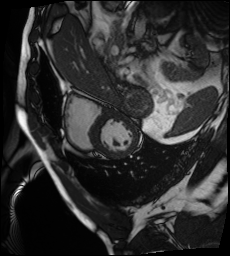

In [ ]:
img()

### Sensitivity to orientation

There are eight posible orientations an image can be in (four rotations by 90° and a flipped variant for each). In misas a series with these 8 items is available via `get_dihedral_series`:

In [ ]:
plot_series(get_dihedral_series(img(),model), nrow=2, figsize=(20,12), param_name="orientation")

  0%|          | 0/8 [00:00<?, ?it/s]

ValueError: Cannot feed value of shape (1, 256, 230, 3, 1) for Tensor 'image:0', which has shape '(None, None, None, 1)'

In the default orientation (0) the network is not successful, however when rotated by 90° clockwise (orientation 5) the prediction looks perfect. This can be explained by the different ways the pixel data is stored in the NifTi and DICOM formats. See [this page](https://nipy.org/nibabel/dicom/dicom_orientation.html#dicom-voxel-to-patient-coordinate-system-mapping) to learn more.

Anyway, as we now know, that (at least for this image) applying a dihedral transformation with parameter 5 yields optimal results we can include this transformation into the preparation function. This way aditional transformations will already use the correctly oriented image as starting point.

In [ ]:
def prep_with_dihedral(image):
    image = image.clone()
    _, X, Y = image.shape
    image.crop_pad((int(math.ceil(X / 16.0)) * 16, int(math.ceil(Y / 16.0)) * 16), padding_mode="zeros")
    return image.dihedral(5)

In [ ]:
model.prepareSize = prep_with_dihedral

### Sensitivity to resize

The next thing that comes to mind when [exploring the images from the kaggle dataset](https://github.com/chfc-cmi/cmr-seg-tl/blob/master/code/kaggle/kaggle_metadata.ipynb) is that image size varies (120px-736px). Being fully convolutional, the `ukbb_cardiac` modell can handle various sizes. Still kernels are trained to work with features of a certain size in pixels so the network cannot be expected to work well with images scaled to arbitrary sizes. Let's explore:

In [ ]:
plot_series(get_resize_series(img(),model, start=50, end=401,step=50), sharex=True, sharey=True, figsize=(20,10), nrow=2)

In fact predictions are very good even for small images (100px), they fail on very small images (50px). For large images, performance starts to get worse for right ventricle with images of 350px and for all other classes at 400px. Given the size range of the images in the dataset we have to worry about some of the larger images. But first we want to get a more quantitative view of the performance depending on size. So we can use the ground truth for the first time to calculate dice scores for each class and each parameter value. This can then be visualized as a line graph:

In [ ]:
results = eval_resize_series(img(),trueMask(),model,end=600,step=30, components=["bg","LV","MY","RV"])

In [ ]:
import altair as alt

In [ ]:
(alt
 .Chart(results.melt(id_vars=['px'],value_vars=['LV','MY','RV'],value_name='dice score'))
 .mark_line()
 .encode(
     x="px",
     y="dice score",
     color="variable",
     tooltip="dice score"
 )
 .properties(width=700,height=300)
 .interactive()
)

Apparently, there is quite a suitable size range. A size of 256px is well within that range so we can include a resize as part of the preparation:

In [ ]:
def prep_with_dihedral_and_resize(image):
    image = prep_with_dihedral(image).clone()
    return image.resize(256).clone()

In [ ]:
model.prepareSize = prep_with_dihedral_and_resize

### Sensitivity to rotation

We already know that orientation is really important. So we might wonder how much rotation will be tolerated. Is a rotation by 5° already a problem or will 30° still be fine? We use the same methods as before to address this question:

In [ ]:
plot_series(get_rotation_series(img(),model, step=30), nrow=2)

In [ ]:
results = eval_rotation_series(img(),trueMask(),model,start=-180,end=180,components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY','RV'],value_name='dice score'))
 .mark_line()
 .encode(
     x="deg",
     y="dice score",
     color="variable",
     tooltip="dice score"
 )
 .properties(width=700,height=300)
 .interactive()
)

There is actually quite some tolerance to rotation. But it is not equal in both directions. Rotations by -80° are no problem for this particular image but only rotations up to +40° are possible without loss in performance.

Another tool `misas` provides to see the effect of a transformation on the prediction more vividly is using gifs:

In [ ]:
gif_series(
    get_rotation_series(img(),model, start=1, end=360,step=10),
    "example/kaggle/rotation_ukbb.gif",
    param_name="deg",
    duration=400
)

![segmentation sensitivity to rotation](example/kaggle/rotation_ukbb.gif)

### Sensitivity to cropping

Next up is the question of what features the network uses to make predictions? Does it use local features only or does it use the larger context, e.g. surrounding organs? As long as the region of interest is at the center of the image we can answer this question by successively cropping more and more contend from the border:

In [ ]:
plot_series(get_crop_series(img(),model, start = 256, step = -25, end=10), nrow=2)

In [ ]:
results = eval_crop_series(img(),trueMask(),model,start = 5, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY','RV'],value_name='dice score'))
 .mark_line()
 .encode(
     x="pixels",
     y="dice score",
     color="variable",
     tooltip="dice score"
 )
 .properties(width=700,height=300)
 .interactive()
)

This analysis indicates that not a lot of context is required for the network to reliably detect the heart (as long as at least the full left ventricle is part of the image). The dice score of 1.0 for MY and RV for very small sizes is due to the fact that the model does not predict anything and indeed there is no MY or RV left on the image. It remains 0.0 for LV as there is always LV on the center crop.

In [ ]:
gif_series(
    get_crop_series(img(),model, start=250, end=5,step=-10),
    "example/kaggle/crop_ukbb.gif",
    param_name="pixels",
    duration=400
)

![segmentation sensitivity to rotation](example/kaggle/crop_ukbb.gif)

### Sensitivity to brightness

Next let's see if the network is very sensitive to brightnes or contrast which would suggest some kind of pre processing, e.g. [adaptive histogram equalization](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization)

In [ ]:
plot_series(get_brightness_series(img(),model, end = 0.99, step = 0.185), nrow=1)

In [ ]:
results = eval_bright_series(img(),trueMask(),model, end = 0.99, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY','RV'],value_name='dice score'))
 .mark_line()
 .encode(
     x="brightness",
     y="dice score",
     color="variable",
     tooltip="dice score"
 )
 .properties(width=700,height=300)
 .interactive()
)

In [ ]:
gif_series(
    get_brightness_series(img(),model, start=0.05, end=0.95,step=0.05),
    "example/kaggle/bright_ukbb.gif",
    param_name="brightness",
    duration=400
)

![sensitivity to brightness](example/kaggle/bright_ukbb.gif)

The network seems to be quite robust to differences in brightness.

### Sensitivity to contrast

In [ ]:
plot_series(get_contrast_series(img(),model, start=0.1, end=3, step=0.5))

In [ ]:
results = eval_contrast_series(img(),trueMask(),model, end = 2.5, step = 0.3, components=["bg","LV","MY","RV"])

In [ ]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY','RV'],value_name='dice score'))
 .mark_line()
 .encode(
     x="contrast",
     y="dice score",
     color="variable",
     tooltip="dice score"
 )
 .properties(width=700,height=300)
 .interactive()
)

In [ ]:
gif_series(
    get_contrast_series(img(),model, start=0.05, end=2.2,step=0.1),
    "example/kaggle/contrast_ukbb.gif",
    param_name="contrast",
    duration=400
)

![segmentation sensitivity to contrast](example/kaggle/contrast_ukbb.gif)

The network seems to be quite robust to differences in contrast.

## References

[1] W. Bai, et al. Automated cardiovascular magnetic resonance image analysis with fully convolutional networks. Journal of Cardiovascular Magnetic Resonance, 20:65, 2018.

## Supplemental Information

If you have the full kaggle dataset you can draw a random sample using this code (omit the seed to really make it random)
```python
#nbdev_fulldata_test
# As we cannot include the whole kaggle dataset in the repo I draw a sample like this:
from glob import glob
from shutil import copy
import os
import random

random.seed(42)
dcm_files = glob("kaggle/train/*/sax_*/*.dcm")
os.makedirs('example/kaggle/sample_images', exist_ok=True)
for f in random.sample(dcm_files,20):
    copy(f, 'example/kaggle/sample_images')
```